In [3]:
import polars as pl
import numpy as np
from datetime import datetime, timedelta
import random


# Machine learing lib
import torch
import torch.nn as nn
import torch.optim as optim
import research


# visualization
import altair as alt
import binance_local as binance

In [4]:
research.set_seed(42)

In [5]:
# Trading pair symbol
sym = 'BTCUSDT'
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [6]:
# old version that's in the video that should no longer used
# binance.download_trades(sym, hist_data_window)

# new version that downloads just the data showed in the video
start_date = datetime(2024, 10, 29, 0, 0)
end_date = datetime(2025, 10, 22, 0, 0)
binance.download_date_range(sym, start_date, end_date)

In [7]:
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [02:17<00:00,  2.61day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-22 19:00:00,107987.7,108379.3,107491.8,107829.0
2025-10-22 20:00:00,107829.1,108032.0,107453.9,107644.4
2025-10-22 21:00:00,107644.4,107694.6,106588.0,107159.8


Loading BTCUSDT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [02:21<00:00,  2.54day/s]


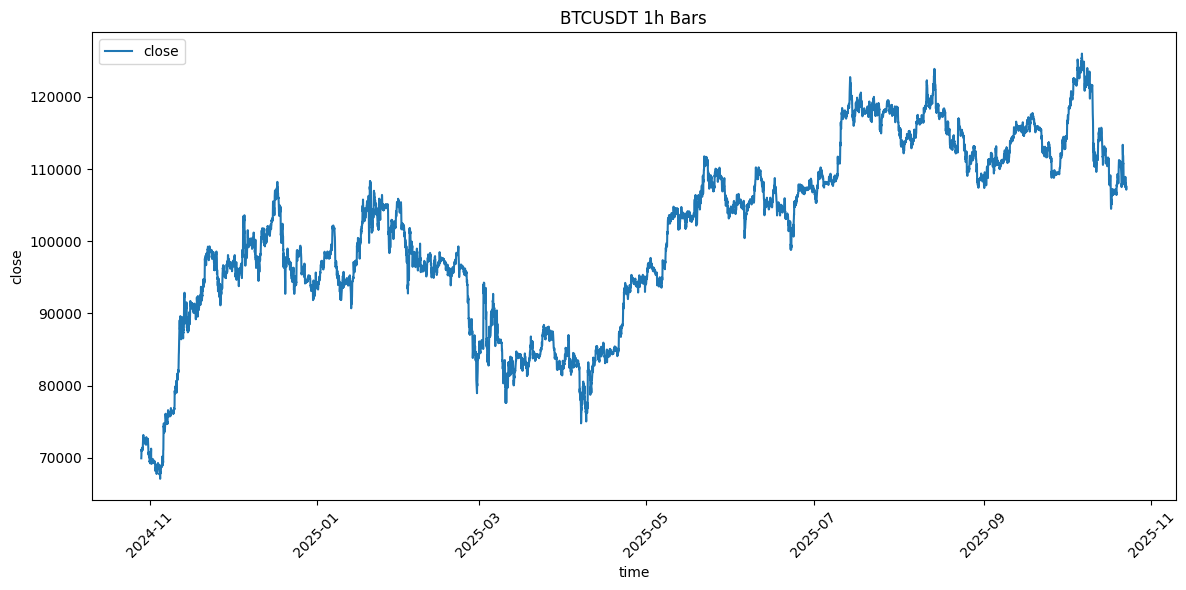

In [8]:
research.load_timeseries_range(sym, time_interval, start_date, end_date, pl.col('price').quantile(0.5).alias('price_median'))
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [50]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

In [51]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [11]:

price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


In [12]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903
…,…,…,…,…,…
2025-10-22 19:00:00,107987.7,108379.3,107491.8,107829.0,-0.001472
2025-10-22 20:00:00,107829.1,108032.0,107453.9,107644.4,-0.001713
2025-10-22 21:00:00,107644.4,107694.6,106588.0,107159.8,-0.004512


In [13]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-22 19:00:00,107987.7,108379.3,107491.8,107829.0,-0.001472,0.002266,-0.00402,-0.001778,-0.004996
2025-10-22 20:00:00,107829.1,108032.0,107453.9,107644.4,-0.001713,-0.001472,0.002266,-0.00402,-0.001778
2025-10-22 21:00:00,107644.4,107694.6,106588.0,107159.8,-0.004512,-0.001713,-0.001472,0.002266,-0.00402


In [14]:
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-22 19:00:00,107987.7,108379.3,107491.8,107829.0,-0.001472,0.002266,-0.00402,-0.001778,-0.004996
2025-10-22 20:00:00,107829.1,108032.0,107453.9,107644.4,-0.001713,-0.001472,0.002266,-0.00402,-0.001778
2025-10-22 21:00:00,107644.4,107694.6,106588.0,107159.8,-0.004512,-0.001713,-0.001472,0.002266,-0.00402


In [15]:
ts = ts.drop_nulls()

In [137]:
# Building of the model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.network(x)

In [138]:
# Complexity of the  model
input_features = 1

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [174]:
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

split_idx = int(len(ts) * (1 - test_size))

ts_train, ts_test = ts[:split_idx],  ts[split_idx:]


In [175]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121,null
…,…,…,…,…,…,…,…,…,…
2025-07-23 08:00:00,118326.9,118687.1,117259.7,118531.0,0.001723,-0.013987,0.009158,0.00794,0.005349
2025-07-23 16:00:00,118530.9,118725.3,117250.0,118713.5,0.001538,0.001723,-0.013987,0.009158,0.00794
2025-07-24 00:00:00,118713.4,119265.4,117050.2,118368.0,-0.002915,0.001538,0.001723,-0.013987,0.009158


In [194]:
# Make sure features and target are aligned
ts_train = ts_train.drop_nans(subset=features + [target])
ts_test  = ts_test.drop_nans(subset=features + [target])

# Now create tensors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(ts_train[features]), dtype=torch.float32)
X_test  = torch.tensor(scaler.transform(ts_test[features]), dtype=torch.float32)

y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32).view(-1, 1)

# Check shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



torch.Size([807, 1]) torch.Size([807, 1])
torch.Size([270, 1]) torch.Size([270, 1])


In [195]:
y_train.shape
y_test.shape

torch.Size([270, 1])

In [196]:

research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[-2.5779e-03],
         [ 4.0192e-03],
         [ 9.5049e-04],
         [-2.4874e-02],
         [-4.4949e-03],
         [-1.4624e-02],
         [ 1.1537e-03],
         [ 1.6489e-03],
         [ 4.5597e-03],
         [-6.0213e-03],
         [-3.9492e-04],
         [-1.4097e-02],
         [-4.6838e-03],
         [ 1.0034e-02],
         [-2.3514e-03],
         [ 1.9969e-04],
         [-1.1439e-02],
         [ 1.5240e-02],
         [ 1.0677e-02],
         [-3.7735e-03],
         [ 5.7202e-02],
         [ 1.1558e-02],
         [ 1.7219e-02],
         [-1.0372e-02],
         [ 1.6989e-02],
         [-2.9248e-03],
         [ 4.0992e-03],
         [ 3.3068e-03],
         [ 7.7041e-04],
         [ 5.4508e-04],
         [-2.8555e-03],
         [ 4.8294e-03],
         [ 2.8074e-02],
         [ 1.1059e-02],
         [ 8.4287e-03],
         [ 9.1349e-03],
         [ 3.5902e-02],
         [ 5.3410e-02],
         [ 4.1221e-03],
         [-2.7716e-02],
         [ 1.5027e-02],
         [-6.490

In [198]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)





print("X_train NaNs:", torch.isnan(X_train).sum().item())
print("X_train Infs:", torch.isinf(X_train).sum().item())
print("y_train NaNs:", torch.isnan(y_train).sum().item())
print("y_train Infs:", torch.isinf(y_train).sum().item())


torch.Size([807, 1]) torch.Size([807, 1])
torch.Size([270, 1]) torch.Size([270, 1])
X_train NaNs: 2
X_train Infs: 0
y_train NaNs: 1
y_train Infs: 0


In [200]:
# hyperparameters
no_epochs = 1000 * 5
lr = 0.001



print(model.parameters())
# create model
model = MLPModel(len(features))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train()
# loss function
criterion = nn.MSELoss()
# optimizer

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)


    # backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")

<generator object Module.parameters at 0x7fb2a78e17e0>

Training model...
Epoch [500/5000], Loss: nan
Epoch [1000/5000], Loss: nan
Epoch [1500/5000], Loss: nan
Epoch [2000/5000], Loss: nan
Epoch [2500/5000], Loss: nan
Epoch [3000/5000], Loss: nan
Epoch [3500/5000], Loss: nan
Epoch [4000/5000], Loss: nan
Epoch [4500/5000], Loss: nan
Epoch [5000/5000], Loss: nan

Learned parameters
network.0.weight:
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
network.0.bias:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

In [26]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000223,0.000291,true,1.0,0.000291,0.000291
0.000113,-0.000817,false,1.0,-0.000817,-0.000527
0.000167,0.007185,true,1.0,0.007185,0.006659
-0.000222,0.002171,false,-1.0,-0.002171,0.004487
0.000022,0.001951,true,1.0,0.001951,0.006438
…,…,…,…,…,…
0.000017,-0.001472,false,1.0,-0.001472,-0.056916
0.000199,-0.001713,false,1.0,-0.001713,-0.058629
0.000211,-0.004512,false,1.0,-0.004512,-0.063141


In [52]:
research.plot_column(trade_results, 'equity_curve')
# Issue with something that I did'nt installed but I think as we can see  in the view that we are not gaining any thing here

alt.Chart(...)

In [28]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000223,0.000291,true,1.0,0.000291,0.000291,0.0
0.000113,-0.000817,false,1.0,-0.000817,-0.000527,-0.000817
0.000167,0.007185,true,1.0,0.007185,0.006659,0.0
-0.000222,0.002171,false,-1.0,-0.002171,0.004487,-0.002171
0.000022,0.001951,true,1.0,0.001951,0.006438,-0.00022
…,…,…,…,…,…,…
0.000017,-0.001472,false,1.0,-0.001472,-0.056916,-0.139933
0.000199,-0.001713,false,1.0,-0.001713,-0.058629,-0.141647
0.000211,-0.004512,false,1.0,-0.004512,-0.063141,-0.146159


In [29]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.16631975769996643

In [30]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.15322457206770967)

In [31]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-153.2245720677097)

In [32]:
win_rate = trade_results['is_won'].mean()

In [34]:
win_rate
# we have a win rate which is smaller than 0.5 which means that we are more loosing than winning. Not a good model....

0.4928007431490943

In [36]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

-2.7716538618921928e-05

In [37]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

-0.05967371538281441

In [38]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(0.9420718670009247)

In [39]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.08330217748880386

In [40]:
equity_peak = trade_results['equity_curve'].max()
equity_peak

0.08301757276058197

In [41]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 2153,
 'win_rate': 0.4928007431490943,
 'avg_win': 0.0024222821003746274,
 'avg_loss': -0.0024081639341978194,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.02237566001713276,
 'ev': -2.7716538618921928e-05,
 'std': 0.0036218115128576756,
 'total_log_return': -0.05967371538281441,
 'compound_return': np.float64(0.9420718670009247),
 'max_drawdown': -0.16631975769996643,
 'equity_trough': -0.08330217748880386,
 'equity_peak': 0.08301757276058197,
 'sharpe': np.float64(-0.7162509328639431)}

In [42]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2153,
 'win_rate': 0.5090571295866233,
 'avg_win': 0.0023639559514838536,
 'avg_loss': -0.0024681746469396356,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.0208609439432621,
 'ev': -8.344114718481866e-06,
 'std': 0.0036219079047441483,
 'total_log_return': -0.01796487718820572,
 'compound_return': np.float64(0.9821955292212018),
 'max_drawdown': -0.2573056221008301,
 'equity_trough': -0.07834261655807495,
 'equity_peak': 0.17896299064159393,
 'sharpe': np.float64(-0.21562291661883395),
 'weights': '[-0.02951752]',
 'biases': '7.51744955778122e-05'}

In [43]:
import itertools

benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:    
    model = LinearModel(len(features))
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, test_size=test_size, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",2153,0.495588,0.002472,-0.002359,0.033952,-0.022376,0.000035,0.003622,0.075843,1.078793,-0.176199,-0.15819,0.138515,0.910339,"""[-0.0320027]""","""8.387765410589054e-05"""
"""close_log_return_lag_2""","""close_log_return""",2153,0.508593,0.002359,-0.002473,0.033952,-0.020861,-0.000016,0.003622,-0.034005,0.966567,-0.257306,-0.093291,0.164015,-0.408146,"""[-0.02928315]""","""7.624620047863573e-05"""
"""close_log_return_lag_4""","""close_log_return""",2153,0.493265,0.002415,-0.002415,0.033952,-0.022376,-0.000032,0.003622,-0.069361,0.93299,-0.187103,-0.098082,0.089021,-0.832536,"""[0.00238027]""","""7.28065351722762e-05"""
"""close_log_return_lag_1""","""close_log_return""",2153,0.493265,0.002375,-0.002455,0.033952,-0.022376,-0.000073,0.003621,-0.156216,0.855374,-0.373327,-0.207085,0.166242,-1.875352,"""[-0.07181929]""","""8.640350279165432e-05"""


In [44]:
research.auto_reg_corr_matrx(ts, target, max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.017178,0.009252,-0.024517,0.012365
-0.017178,1.0,-0.017206,0.009439,-0.024442
0.009252,-0.017206,1.0,-0.017416,0.009354
-0.024517,0.009439,-0.017416,1.0,-0.017153
0.012365,-0.024442,0.009354,-0.017153,1.0


In [53]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [56]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.000218,0.000291,true,1.0,0.000291,0.000291,0.0,-0.0006,-0.00031,-0.00031
0.000134,-0.000817,false,1.0,-0.000817,-0.000527,-0.000817,-0.0006,-0.001418,-0.001727
0.000068,0.007185,true,1.0,0.007185,0.006659,0.0,-0.0006,0.006585,0.004858
0.0001,0.002171,true,1.0,0.002171,0.00883,0.0,-0.0006,0.001571,0.006429
-0.000134,0.001951,false,-1.0,-0.001951,0.006879,-0.001951,-0.0006,-0.002551,0.003878
…,…,…,…,…,…,…,…,…,…
0.000194,-0.001472,false,1.0,-0.001472,-0.031247,-0.195261,-0.0006,-0.002072,-1.321034
0.00001,-0.001713,false,1.0,-0.001713,-0.03296,-0.196975,-0.0006,-0.002314,-1.323347
0.000119,-0.004512,false,1.0,-0.004512,-0.037472,-0.201487,-0.0006,-0.005112,-1.32846


In [57]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [58]:
!pip install "vl-convert-python>=1.6.0"

In [59]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [60]:
model_trades['is_won'].mean()

0.5085926614026939

In [61]:
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
0.000218,0.000291,true,1.0,0.000291,0.000291,0.0,-0.0006,-0.00031,-0.00031,-9.21005,-8.111437,-9.21005,-8.111437
0.000134,-0.000817,false,1.0,-0.000817,-0.000527,-0.000817,-0.0006,-0.001418,-0.001727,-9.211158,-8.112545,-18.421208,-16.223983
0.000068,0.007185,true,1.0,0.007185,0.006659,0.0,-0.0006,0.006585,0.004858,-9.203155,-8.104543,-27.624363,-24.328526
0.0001,0.002171,true,1.0,0.002171,0.00883,0.0,-0.0006,0.001571,0.006429,-9.208169,-8.109557,-36.832532,-32.438082
-0.000134,0.001951,false,-1.0,-0.001951,0.006879,-0.001951,-0.0006,-0.002551,0.003878,-9.212292,-8.113679,-46.044823,-40.551762
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000194,-0.001472,false,1.0,-0.001472,-0.031247,-0.195261,-0.0006,-0.002072,-1.321034,-9.211812,-8.1132,-19793.052706,-17432.134898
0.00001,-0.001713,false,1.0,-0.001713,-0.03296,-0.196975,-0.0006,-0.002314,-1.323347,-9.212054,-8.113442,-19802.26476,-17440.248339
0.000119,-0.004512,false,1.0,-0.004512,-0.037472,-0.201487,-0.0006,-0.005112,-1.32846,-9.214852,-8.11624,-19811.479612,-17448.364579


In [63]:
time_interval = '8h'
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [02:26<00:00,  2.46day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8
…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1


In [64]:
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121
…,…,…,…,…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2,0.04821,-0.022427,-0.005499,-0.000424
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7,-0.046049,0.04821,-0.022427,-0.005499
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1,0.000281,-0.046049,0.04821,-0.022427


In [70]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",269,0.550186,0.007307,-0.007814,0.04821,-0.05397,0.000505,0.010815,0.135902,1.14557,-0.16843,-0.024409,0.193052,4.372184,"""[-0.03461572]""","""0.0006079721497371793"""
"""close_log_return_lag_3""","""close_log_return""",269,0.531599,0.007206,-0.007909,0.04821,-0.05397,0.000126,0.010826,0.033913,1.034495,-0.180149,-0.023952,0.156197,1.089915,"""[-0.05930929]""","""0.0006263444665819407"""
"""close_log_return_lag_2""","""close_log_return""",269,0.527881,0.007066,-0.008059,0.04821,-0.05397,-0.000075,0.010827,-0.02005,0.98015,-0.177344,-0.048823,0.128521,-0.644341,"""[-0.03404887]""","""0.0006090261158533394"""


In [73]:
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.03947,-0.024263,-0.054349
-0.03947,1.0,-0.039623,-0.024935
-0.024263,-0.039623,1.0,-0.03914
-0.054349,-0.024935,-0.03914,1.0


In [74]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",269,0.546468,0.007326,-0.007786,0.04821,-0.05397,0.000472,0.010817,0.127041,1.135464,-0.16843,-0.024409,0.18419,4.086545,"""[-0.03563489]""","""0.0006023393361829221"""
"""close_log_return_lag_3""","""close_log_return""",269,0.535316,0.007181,-0.007942,0.04821,-0.05397,0.000154,0.010826,0.0413,1.042164,-0.180149,-0.020648,0.163584,1.327356,"""[-0.05880521]""","""0.0006206232355907559"""
"""close_log_return_lag_2""","""close_log_return""",269,0.527881,0.007066,-0.008059,0.04821,-0.05397,-0.000075,0.010827,-0.02005,0.98015,-0.177344,-0.048823,0.128521,-0.644341,"""[-0.03364578]""","""0.0006044502952136099"""


In [75]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",269,0.561338,0.007369,-0.007748,0.04821,-0.05397,0.000738,0.010802,0.198401,1.219451,-0.132799,0.003451,0.215834,6.390783,"""[-0.05009809]""","""0.0002856440842151642"""
"""close_log_return_lag_3""","""close_log_return""",269,0.524164,0.006941,-0.00819,0.04821,-0.05397,-0.000259,0.010824,-0.069652,0.932719,-0.16843,-0.087987,0.080443,-2.239002,"""[-0.00134411]""","""0.00043429326615296304"""
"""close_log_return_lag_2""","""close_log_return""",269,0.509294,0.00714,-0.007945,0.04821,-0.05397,-0.000262,0.010824,-0.070563,0.931869,-0.244654,-0.070563,0.174091,-2.2683,"""[-0.05992604]""","""0.00033765239641070366"""


In [81]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)

print(model_trades)

shape: (269, 11)
┌───────────┬───────────┬────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ y_pred    ┆ y_true    ┆ is_won ┆ position ┆ … ┆ trade_log_ ┆ trade_log_ ┆ equity_cur ┆ equity_cu │
│ ---       ┆ ---       ┆ ---    ┆ ---      ┆   ┆ return_net ┆ return_net ┆ ve_net_mak ┆ rve_net_t │
│ f32       ┆ f32       ┆ bool   ┆ f32      ┆   ┆ _maker     ┆ _taker     ┆ er         ┆ aker      │
│           ┆           ┆        ┆          ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│           ┆           ┆        ┆          ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
╞═══════════╪═══════════╪════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 0.001557  ┆ 0.003451  ┆ true   ┆ 1.0      ┆ … ┆ -9.206889  ┆ -8.108277  ┆ -9.206889  ┆ -8.108277 │
│ 0.000111  ┆ 0.016257  ┆ true   ┆ 1.0      ┆ … ┆ -9.194083  ┆ -8.095471  ┆ -18.400972 ┆ -16.20374 │
│           ┆           ┆        ┆          ┆   ┆            ┆            

In [83]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [84]:
research.plot_column(model_trades, 'equity_curve_net_maker')

alt.Chart(...)

In [85]:
time_interval = '12h'
no_lags = 4
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null,null,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null,null,null,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025,0.019121,null,null
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824,0.005025,0.019121,null
…,…,…,…,…,…,…,…,…,…
2025-10-21 08:00:00,108019.9,113480.0,107432.8,113355.2,0.04821,-0.022427,-0.005499,-0.000424,0.023122
2025-10-21 16:00:00,113355.2,113940.0,108000.0,108253.7,-0.046049,0.04821,-0.022427,-0.005499,-0.000424
2025-10-22 00:00:00,108253.8,108649.4,107558.1,108284.1,0.000281,-0.046049,0.04821,-0.022427,-0.005499


In [87]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.548507,0.00736,-0.007781,0.04821,-0.05397,0.000524,0.010832,0.140469,1.150814,-0.188515,-0.022829,0.206705,4.528734,"""[-0.03528055 -0.0359978 ]""","""0.0006243863026611507"""
"""close_log_return_lag_1""","""close_log_return""",268,0.548507,0.007333,-0.007814,0.04821,-0.05397,0.000494,0.010834,0.132451,1.141623,-0.16843,-0.02786,0.1896,4.269652,"""[-0.03521843]""","""0.0006158141768537462"""
"""close_log_return_lag_2,close_l…","""close_log_return""",268,0.541045,0.007312,-0.007831,0.04821,-0.05397,0.000362,0.010839,0.09711,1.101981,-0.149723,-0.04284,0.173381,3.128902,"""[-0.03567574 -0.05964991]""","""0.0006472921231761575"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.552239,0.007127,-0.008072,0.04821,-0.05397,0.000321,0.01084,0.086123,1.08994,-0.203786,-0.04284,0.216457,2.774574,"""[-0.03798401 -0.03703791 -0.06…","""0.000671212503220886"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.522388,0.007461,-0.007648,0.04821,-0.05397,0.000244,0.010842,0.065497,1.06769,-0.187149,-0.081577,0.105572,2.109701,"""[-0.03587842 -0.06031595]""","""0.0006468737265095115"""
"""close_log_return_lag_3""","""close_log_return""",268,0.529851,0.007232,-0.007909,0.04821,-0.05397,0.000114,0.010844,0.030462,1.03093,-0.180149,-0.027404,0.152745,0.980982,"""[-0.05926593]""","""0.0006325107533484697"""
"""close_log_return_lag_2""","""close_log_return""",268,0.526119,0.007092,-0.008059,0.04821,-0.05397,-0.000088,0.010845,-0.023501,0.976773,-0.177344,-0.052274,0.125069,-0.756813,"""[-0.03364655]""","""0.0006093389820307493"""


In [88]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.548507,0.00736,-0.007781,0.04821,-0.05397,0.000524,0.010832,0.140469,1.150814,-0.188515,-0.022829,0.206705,4.528734,"""[-0.03519413 -0.0359067 ]""","""0.0006366177112795413"""
"""close_log_return_lag_1""","""close_log_return""",268,0.548507,0.007333,-0.007814,0.04821,-0.05397,0.000494,0.010834,0.132451,1.141623,-0.16843,-0.02786,0.1896,4.269652,"""[-0.03485096]""","""0.0006123814382590353"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.552239,0.007127,-0.008072,0.04821,-0.05397,0.000321,0.01084,0.086123,1.08994,-0.203786,-0.04284,0.216457,2.774574,"""[-0.03792759 -0.03695513 -0.06…","""0.0006688098073936999"""
"""close_log_return_lag_2,close_l…","""close_log_return""",268,0.541045,0.007248,-0.007906,0.04821,-0.05397,0.000293,0.010841,0.078531,1.081697,-0.168301,-0.04284,0.173381,2.529806,"""[-0.03152116 -0.06375228]""","""0.0006523775518871844"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.522388,0.007461,-0.007648,0.04821,-0.05397,0.000244,0.010842,0.065497,1.06769,-0.187149,-0.081577,0.105572,2.109701,"""[-0.03533089 -0.06127252]""","""0.0006528240628540516"""
"""close_log_return_lag_3""","""close_log_return""",268,0.529851,0.007232,-0.007909,0.04821,-0.05397,0.000114,0.010844,0.030462,1.03093,-0.180149,-0.027404,0.152745,0.980982,"""[-0.05882025]""","""0.0006314545753411949"""
"""close_log_return_lag_2""","""close_log_return""",268,0.526119,0.007092,-0.008059,0.04821,-0.05397,-0.000088,0.010845,-0.023501,0.976773,-0.177344,-0.052274,0.125069,-0.756813,"""[-0.03392334]""","""0.0006146464729681611"""


In [89]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.L1Loss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.559701,0.007275,-0.0079,0.04821,-0.05397,0.000594,0.010829,0.159068,1.172418,-0.132799,-0.011638,0.176502,5.130055,"""[-0.05381488 -0.00173372]""","""0.00032299719168804586"""
"""close_log_return_lag_1""","""close_log_return""",268,0.55597,0.007312,-0.007848,0.04821,-0.05397,0.000581,0.010829,0.155615,1.168377,-0.132799,-0.031421,0.173049,5.018378,"""[-0.05483229]""","""0.00034082107595168054"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.541045,0.007287,-0.00786,0.04821,-0.05397,0.000335,0.01084,0.089837,1.093995,-0.181453,0.002829,0.184282,2.894322,"""[-0.07082979 -0.0801533 -0.00…","""0.00031874183332547545"""
"""close_log_return_lag_1,close_l…","""close_log_return""",268,0.526119,0.007292,-0.007837,0.04821,-0.05397,0.000122,0.010844,0.032798,1.033342,-0.205466,-0.054209,0.151256,1.05625,"""[-0.06885266 -0.07817581]""","""0.00035426803515292704"""
"""close_log_return_lag_3""","""close_log_return""",268,0.522388,0.006966,-0.00819,0.04821,-0.05397,-0.000273,0.010842,-0.073103,0.929505,-0.16843,-0.091439,0.076992,-2.354833,"""[0.0018448]""","""0.00045542954467236996"""
"""close_log_return_lag_2""","""close_log_return""",268,0.503731,0.007201,-0.007905,0.04821,-0.05397,-0.000295,0.010841,-0.079159,0.923893,-0.244654,-0.079159,0.165494,-2.550047,"""[-0.06634763]""","""0.00039516526157967746"""
"""close_log_return_lag_2,close_l…","""close_log_return""",268,0.5,0.007138,-0.007963,0.04821,-0.05397,-0.000412,0.010837,-0.110491,0.895394,-0.270655,-0.110491,0.160164,-3.560638,"""[-0.06066899 0.00447161]""","""0.00037919572787359357"""


In [90]:

features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [91]:
torch.save(model.state_dict(), 'model_weights.pth')